# DmX Challenge: Predictive Credit Risk Modeling Using Customer Credit Scores and Phone Footprints


In [1]:
# ──────────────────────────────────────────────────────────────────────────
# Script Name : training_etl.py
# Author      : Dilan Castañeda, Paulo Ibarra, Bruno Díaz, Fatima Quintana
# Created On  : September 18, 2024
# Last Update : September 23, 2024
# Version     : 0.0.4
# Description : Credit risk modeling using bureau reports and phone data to predict client default probability.
#──────────────────────────────────────────────────────────────────────────

## Overview

---
Instituto Tecnológico y de Estudios Superiores de Monterrey

Analítica de datos y herramientas de inteligencia artificial TI3001C.103

Profesor: Enrique Ricardo García Hernández

Equipo 2:
*   Dilan González Castañeda             A00831905
*   Fátima Pamela Ramón Quintana         A00833076
*   Paulo Ibarra A01632632
*   Bruno Díaz Flores A0082455


---

**Overview**

Credit risk modeling using bureau reports and phone usage data to predict client default probability for loan approval decisions.

**Database Source**

The database for this project was provided by DMX, containing comprehensive credit bureau reports and detailed phone usage data for each client.

**Key Components**

1. Credit Bureau Data:

* Credit history
* Loan inquiries
* Payment behaviors
* Current debt levels


2. Phone Usage Data:

* Subscription type
* Usage patterns
* Payment history
* Device information


3.  Target Variable:

* Client default status (binary: defaulted or not)



**Project Goals**

Develop a predictive model to assess the likelihood of client loan default
Optimize loan approval decisions based on calculated risk
Enhance the overall loan portfolio quality by minimizing potential defaults

**Methodology**

* Utilize machine learning techniques to analyze historical data
* Incorporate both traditional credit metrics and alternative data (phone usage)
* Create a robust model that can handle various data types and complex relationships

**Expected Outcome**
A reliable credit risk assessment tool that can:

* Accurately predict client default probability
* Assist in making informed loan approval decisions
* Potentially increase approval rates for creditworthy clients while minimizing risk

This project aims to leverage the unique combination of traditional credit data and alternative phone usage data provided by DMX to create a more comprehensive and accurate credit risk assessment model.

### 1. ETL for Model Training

#### Purpose
- Prepare historical data for model development and training.

#### Process
1. **Extract**:
   - Pull historical data from DMX database (credit bureau reports and phone usage data).
   - Include all available features and the target variable (default status).

2. **Transform**:
   - Handle missing values, outliers, and data quality issues.
   - Perform feature engineering (e.g., creating interaction terms, deriving new features).
   - Encode categorical variables.
   - Normalize or standardize numerical features.

3. **Load**:
   - Store the processed data in a format suitable for model training (e.g., parquet files, a data warehouse).

#### Benefits
- Can perform extensive data cleaning and feature engineering.
- Allows for complex transformations that might be computationally expensive.
- Can use the full historical dataset for better feature creation and selection.

By implementing separate ETL processes for training and scoring, we can optimize our credit risk model for both comprehensive learning from historical data and efficient, consistent scoring of new records.

## ETL

### Extract

In [2]:
%pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Define the path to the file
# Using the file inside the repository
file_name = r'C:\Users\dilan\Documents\Github\DataAnalysis_and_AI\period_2\Resources\Challenge\base_Reto.csv'
# Using the file from the repository
url = 'https://raw.githubusercontent.com/magotronico/DataAnalysis_and_AI/main/period_2/Resources/Challenge/base_Reto.csv'

# Load original DataBase (csv)
df = pd.read_csv(url, encoding='latin-1') # You can use the file_name variable to load the file if you have it in your local machine
df = pd.read_csv(url, encoding='latin-1')

# Display the first 3 rows of the dataframe
df.head(3)
# Display resume of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25101 entries, 0 to 25100
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Solicitud_id                             25101 non-null  float64
 1   Aprobado                                 25101 non-null  int64  
 2   Hit_Buro_Huella                          25101 non-null  int64  
 3   Malo                                     25101 non-null  int64  
 4   Num_IQ_U3M_PL_Financieras                25101 non-null  int64  
 5   Edad_cliente                             25101 non-null  int64  
 6   Porcentaje_cuentas_abiertas              25101 non-null  float64
 7   Num_IQ_U3M                               25101 non-null  int64  
 8   Num_IQ_U3M_TDC_Banco                     25101 non-null  int64  
 9   MaxMOP_U3M                               25101 non-null  int64  
 10  Saldo_actual_prest_personales            25101

### Transform


#### Estandarize column names

In [5]:
#Create a copy of the original dataframe
df_copy = df.copy(deep=True)
# Estandarize columns names (lowercase and without accents)
df_copy.columns = [unidecode(str(col)).lower() for col in df.columns]
# Replace 'contabilidad' with 'contactabilidad' in column name
df_copy.columns = df_copy.columns.str.replace('contabilidad', 'contactabilidad')

#### Create 4 DataFrame (1 per ScoreCard)

In [6]:
# Creating separate dataframes for each 'Hit_Buro_Huella' value
df_score_1 = df_copy[df_copy['hit_buro_huella'] == 0].copy(deep=True)
df_score_2 = df_copy[df_copy['hit_buro_huella'] == 1].copy(deep=True)
df_score_3 = df_copy[df_copy['hit_buro_huella'] == 10].copy(deep=True)
df_score_4 = df_copy[df_copy['hit_buro_huella'] == 11].copy(deep=True)

#### Categorize DB based on hit_buro_huella (ScoreCards)

In [7]:
# Split hit_buro_huella into hit_buro and hit_huella
df_copy['hit_buro_huella'] = df_copy['hit_buro_huella'].apply(lambda x: f'{x:02d}')
df_copy['hit_buro'] = df_copy['hit_buro_huella'].str[0].astype(int)
df_copy['hit_huella'] = df_copy['hit_buro_huella'].str[1].astype(int)
df_copy.insert(3, 'hit_buro', df_copy.pop('hit_buro'))
df_copy.insert(4, 'hit_huella', df_copy.pop('hit_huella'))
df_copy.drop('hit_buro_huella', axis=1, inplace=True)

# Grouping info by hit_buro and hit_huella into 4 categories: {1: 00, 2: 01, 3: 10, 4: 11}
df_copy['hit_group'] = df_copy['hit_buro'].astype(str) + df_copy['hit_huella'].astype(str)
df_copy['hit_group'] = df_copy['hit_group'].map({'00': 1, '01': 2, '10': 3, '11': 4})
df_copy.insert(4, 'hit_group', df_copy.pop('hit_group'))

#### Basic Data Exploration on ScoreCards

1. No Credit Score and No Phone Footprint
2. No Credit Score and Phone Footprint
3. Credit Score and No Phone Footprint
4. Credit Score and Phone Footprint

* Check if there are sufficient observations for ScoreCards. For each ScoreCard:
    * Approval rate (approved by attended)
    * Delinquency rate (bad among observations once approved)
    * Number of observations (of each scorecard with performance and at least 20% with bad outcomes)

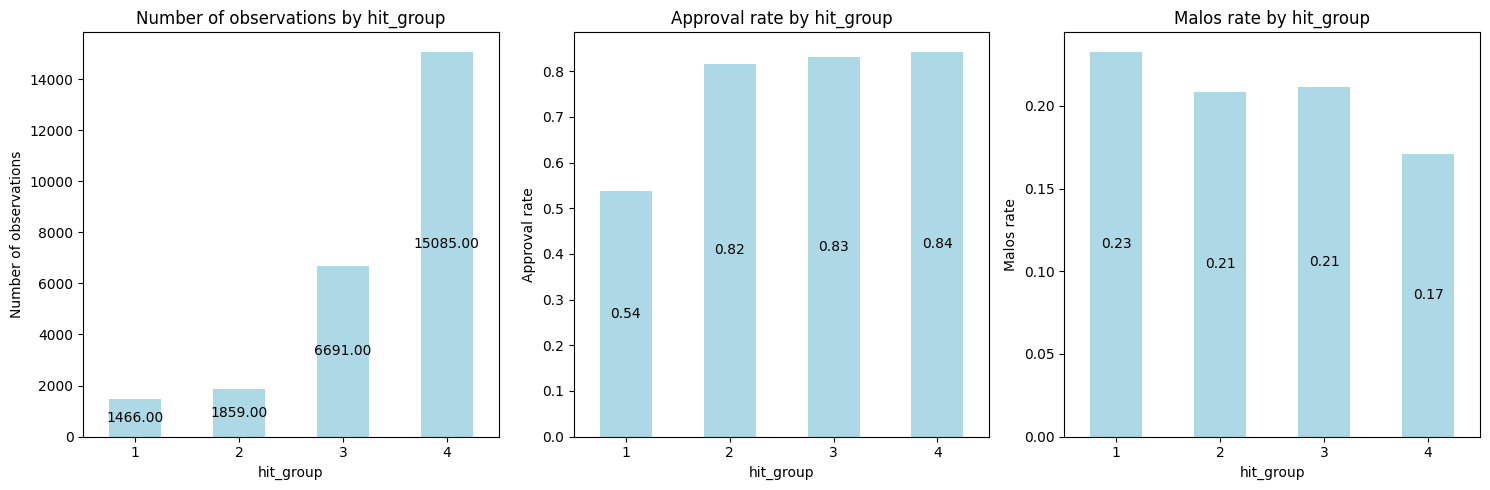

In [8]:
# Number of observations by hit_group
obs_by_hit_group = df_copy['hit_group'].value_counts().sort_index()

# Approval rate by hit_group
approval_rate_by_hit_group = df_copy.groupby('hit_group')['aprobado'].mean()

# Delinquency rate by hit_group: mean of 'malo' column if 'aprobado' == 1
malos_rate_by_hit_group = df_copy[(df_copy['aprobado'] == 1) & (df_copy['malo'] >= 0)].groupby('hit_group')['malo'].mean()

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Number of observations by hit_group
obs_by_hit_group.plot(kind='bar', ax=ax[0], color='lightblue')
ax[0].set_title('Number of observations by hit_group')
ax[0].set_xlabel('hit_group')
ax[0].set_ylabel('Number of observations')

# Approval rate by hit_group
approval_rate_by_hit_group.plot(kind='bar', ax=ax[1], color='lightblue')
ax[1].set_title('Approval rate by hit_group')
ax[1].set_xlabel('hit_group')
ax[1].set_ylabel('Approval rate')

# Delinquency rate by hit_group
malos_rate_by_hit_group.plot(kind='bar', ax=ax[2], color='lightblue')
ax[2].set_title('Malos rate by hit_group')
ax[2].set_xlabel('hit_group')
ax[2].set_ylabel('Malos rate')

for i in range(3):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() / 2.), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Distribution of Age, Gross Income and maxMOp and Morosity

##### Age & Morosity

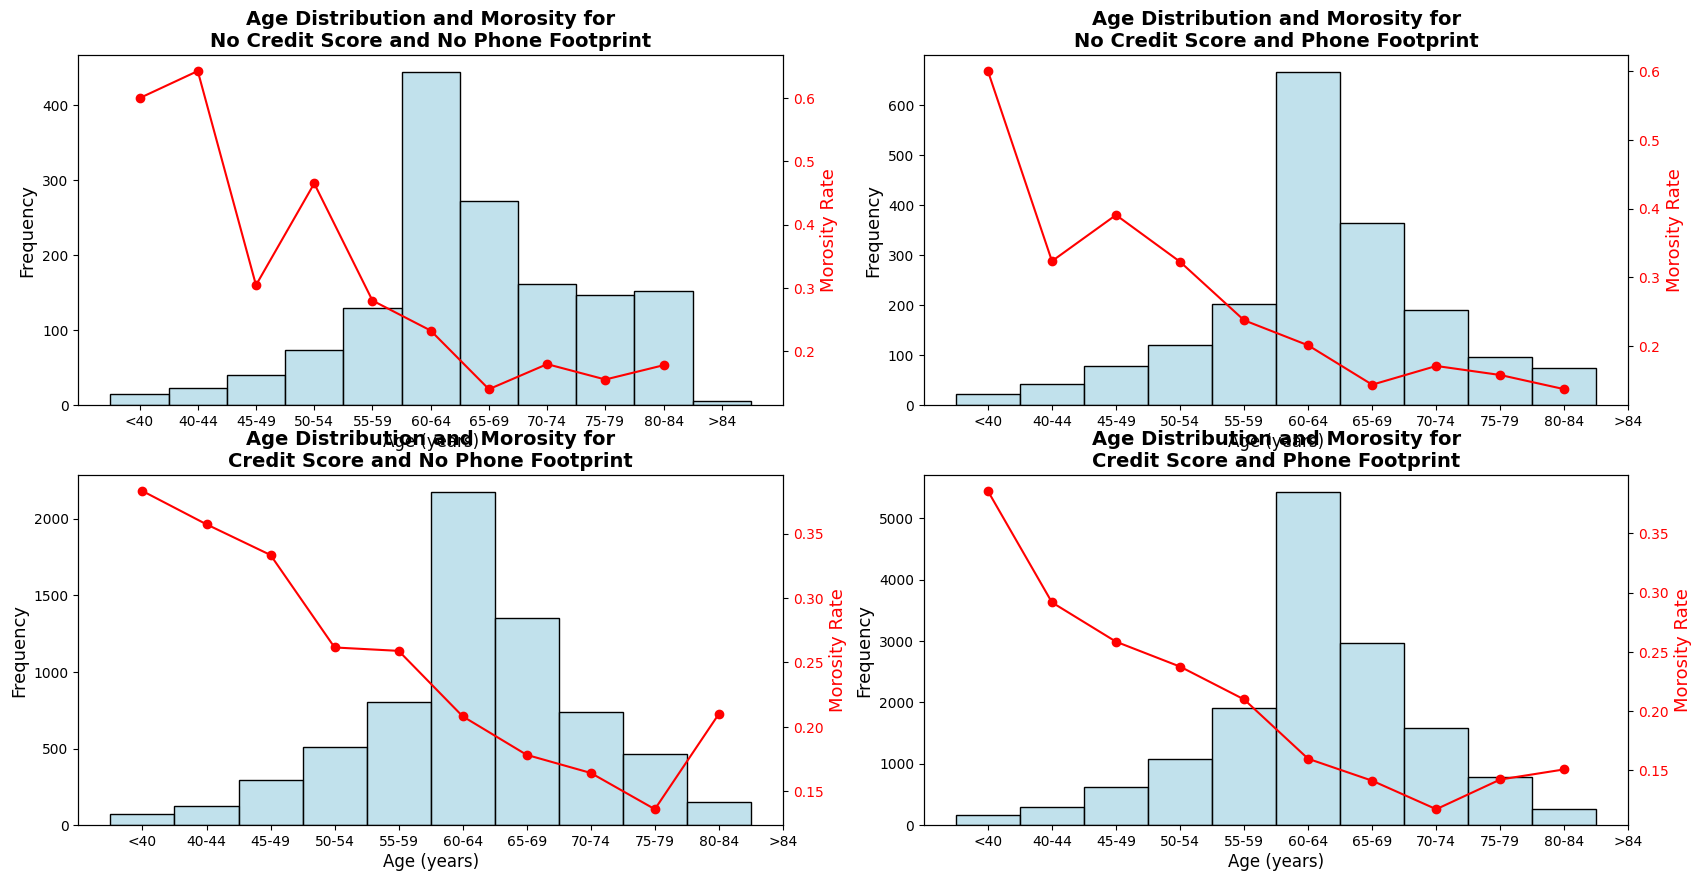

In [9]:
# Dataframes, their labels, and descriptive titles
groups_name = {
    'df_score_1': 'No Credit Score and No Phone Footprint',
    'df_score_2': 'No Credit Score and Phone Footprint',
    'df_score_3': 'Credit Score and No Phone Footprint',
    'df_score_4': 'Credit Score and Phone Footprint'
}

# Define custom bins and labels
bins = [0, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 150]  # Adding bins for <40 and >84
labels = ['<40', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>84']


# Age Distribution before scaling
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for i in range(1, 5):
    df = globals()[f'df_score_{i}'].copy(deep=True)

    # Categorize the data into the defined bins
    df['age_binned'] = pd.cut(df['edad_cliente'], bins=bins, labels=labels, right=False)

    # Morosity rate by age group (assuming 'malo' is 1 for morose and 0 for non-morose)
    morosity_rate_by_age_group = df[df['aprobado'] == 1].groupby('age_binned', observed=True)['malo'].mean()

    # Plot the distribution of age groups (histogram)
    sns.histplot(df['age_binned'], ax=ax[(i-1)//2][(i-1)%2], color='lightblue')

    # Plot the morosity rate by age group (line plot)
    ax2 = ax[(i-1)//2][(i-1)%2].twinx()  # Create a second y-axis to plot the morosity rate
    ax2.plot(morosity_rate_by_age_group.index, morosity_rate_by_age_group.values, color='red', marker='o')
    ax2.set_ylabel('Morosity Rate', fontsize=13, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and labels
    ax[(i-1)//2][(i-1)%2].set_title(f'Age Distribution and Morosity for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
    ax[(i-1)//2][(i-1)%2].set_xlabel('Age (years)', fontsize=12, labelpad=3)
    ax[(i-1)//2][(i-1)%2].set_ylabel('Frequency', fontsize=13)

plt.show()

##### Device Range & Morosity

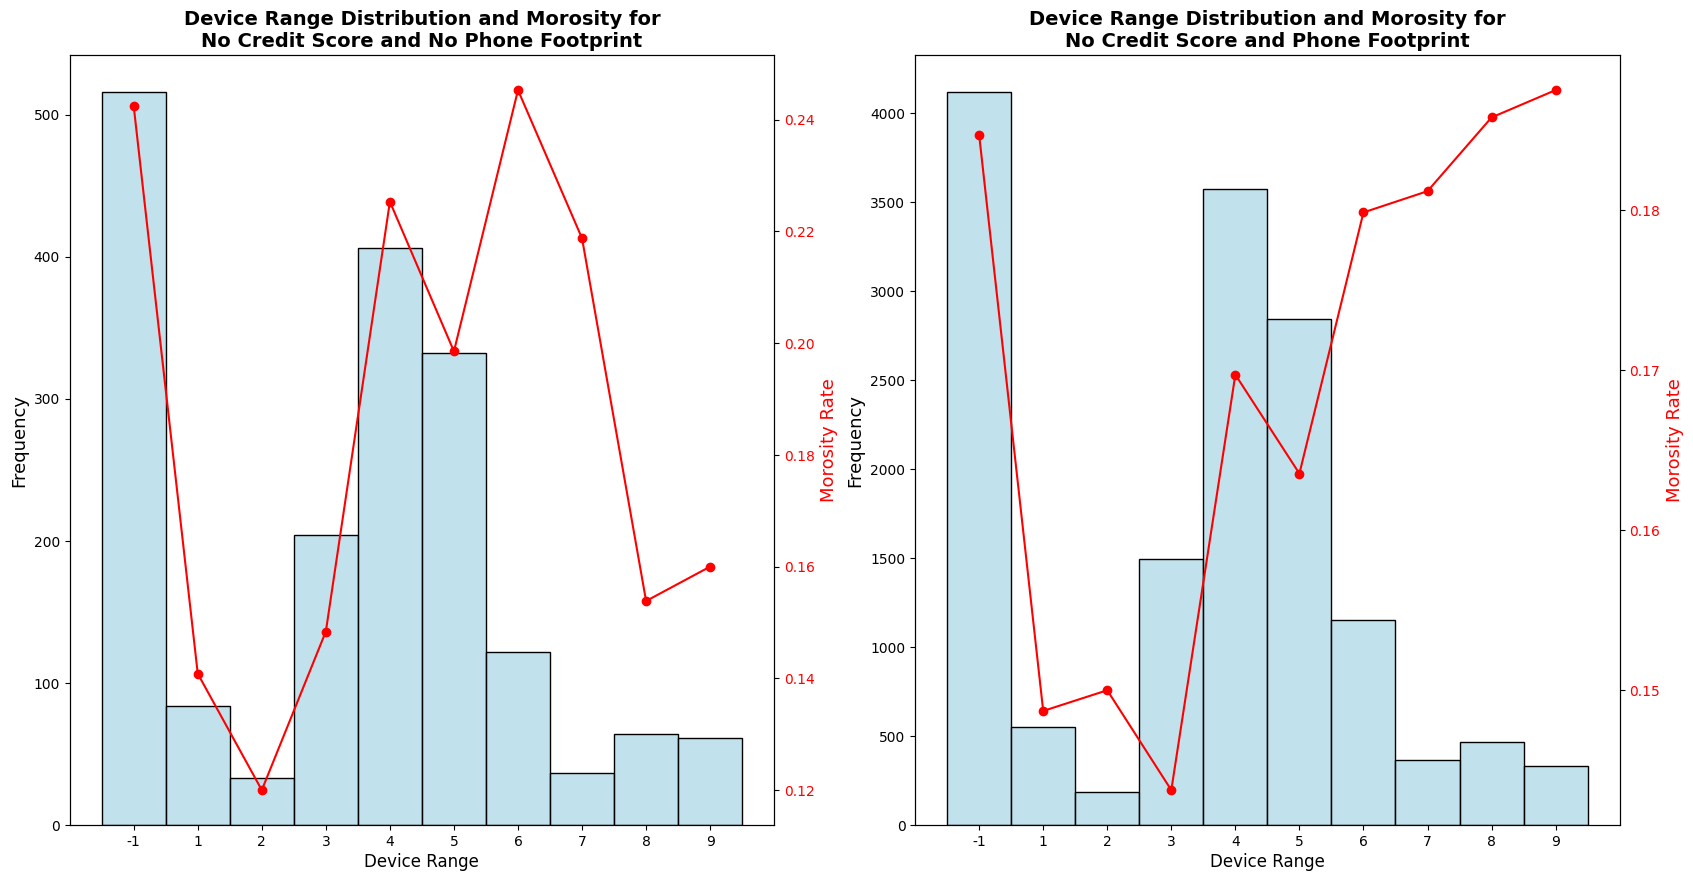

In [10]:
# Define custom bins and labels
bins = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['-1', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Age Distribution before scaling
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjust to 1 row and 2 columns since you're plotting only 2 DataFrames

# Only process df_score_2 and df_score_4
for i, score in enumerate([2, 4], start=1):
    df = globals()[f'df_score_{score}'].copy(deep=True)

    # Categorize the data into the defined bins
    df['rango_binned'] = pd.cut(df['rango_dispositivo'], bins=bins, labels=labels, right=False)

    # Morosity rate by age group (assuming 'malo' is 1 for morose and 0 for non-morose)
    morosity_rate_by_age_group = df[df['aprobado'] == 1].groupby('rango_binned', observed=True)['malo'].mean()

    # Plot the distribution of age groups (histogram)
    sns.histplot(df['rango_binned'], ax=ax[i-1], color='lightblue')

    # Plot the morosity rate by age group (line plot)
    ax2 = ax[i-1].twinx()  # Create a second y-axis to plot the morosity rate
    ax2.plot(morosity_rate_by_age_group.index, morosity_rate_by_age_group.values, color='red', marker='o')
    ax2.set_ylabel('Morosity Rate', fontsize=13, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and labels
    ax[i-1].set_title(f'Device Range Distribution and Morosity for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
    ax[i-1].set_xlabel('Device Range', fontsize=12, labelpad=3)
    ax[i-1].set_ylabel('Frequency', fontsize=13)

plt.show()

##### Maximum payment management of the last 3 months (MaxMOP_U3M) & Morosity

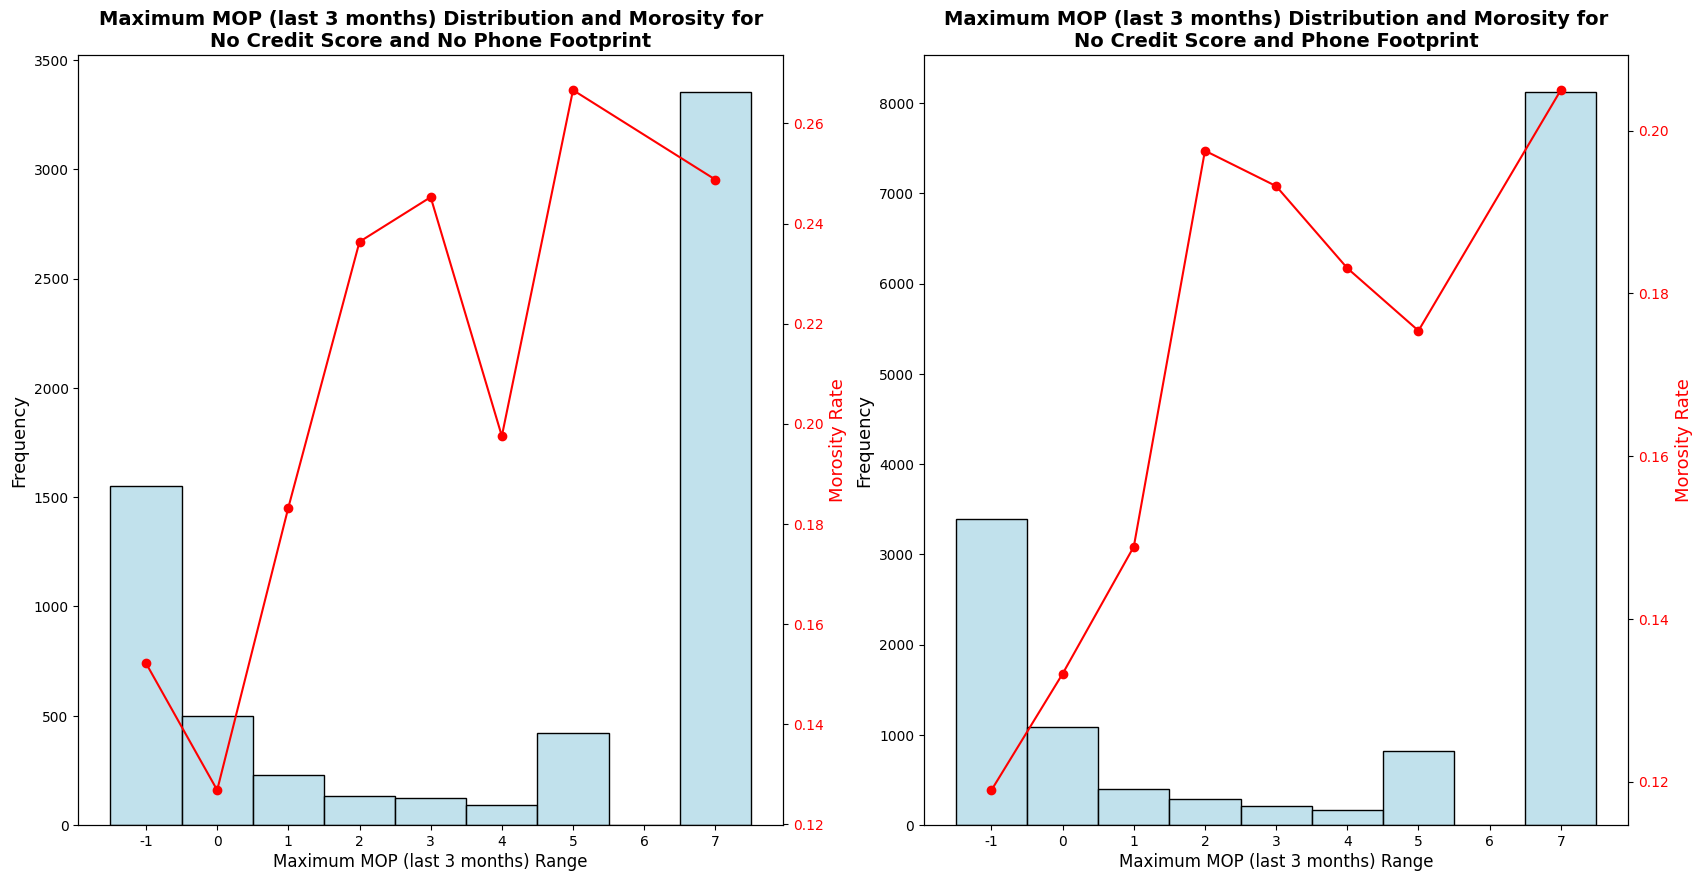

In [11]:
# Define custom bins and labels for maxmop_u3m
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
labels = ['-1','0', '1', '2', '3', '4', '5', '6', '7', '9']

# Distribution before scaling
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjust to 1 row and 2 columns since you're plotting only 2 DataFrames

# Only process df_score_2 and df_score_4
for i, score in enumerate([3, 4], start=1):
    df = globals()[f'df_score_{score}'].copy(deep=True)

    # Categorize the data into the defined bins for maxmop_u3m
    df['maxmop_u3m_binned'] = pd.cut(df['maxmop_u3m'], bins=bins, labels=labels, right=False)

    # Morosity rate by maxmop_u3m group (assuming 'malo' is 1 for morose and 0 for non-morose)
    morosity_rate_by_maxmop_u3m_group = df[df['aprobado'] == 1].groupby('maxmop_u3m_binned', observed=True)['malo'].mean()

    # Plot the distribution of maxmop_u3m groups (histogram)
    sns.histplot(df['maxmop_u3m_binned'], ax=ax[i-1], color='lightblue')

    # Plot the morosity rate by maxmop_u3m group (line plot)
    ax2 = ax[i-1].twinx()  # Create a second y-axis to plot the morosity rate
    ax2.plot(morosity_rate_by_maxmop_u3m_group.index, morosity_rate_by_maxmop_u3m_group.values, color='red', marker='o')
    ax2.set_ylabel('Morosity Rate', fontsize=13, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and labels
    ax[i-1].set_title(f'Maximum MOP (last 3 months) Distribution and Morosity for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
    ax[i-1].set_xlabel('Maximum MOP (last 3 months) Range', fontsize=12, labelpad=3)
    ax[i-1].set_ylabel('Frequency', fontsize=13)

plt.show()

##### ingreso_bruto & Morosity

Before outliers correction in ingreso_bruto

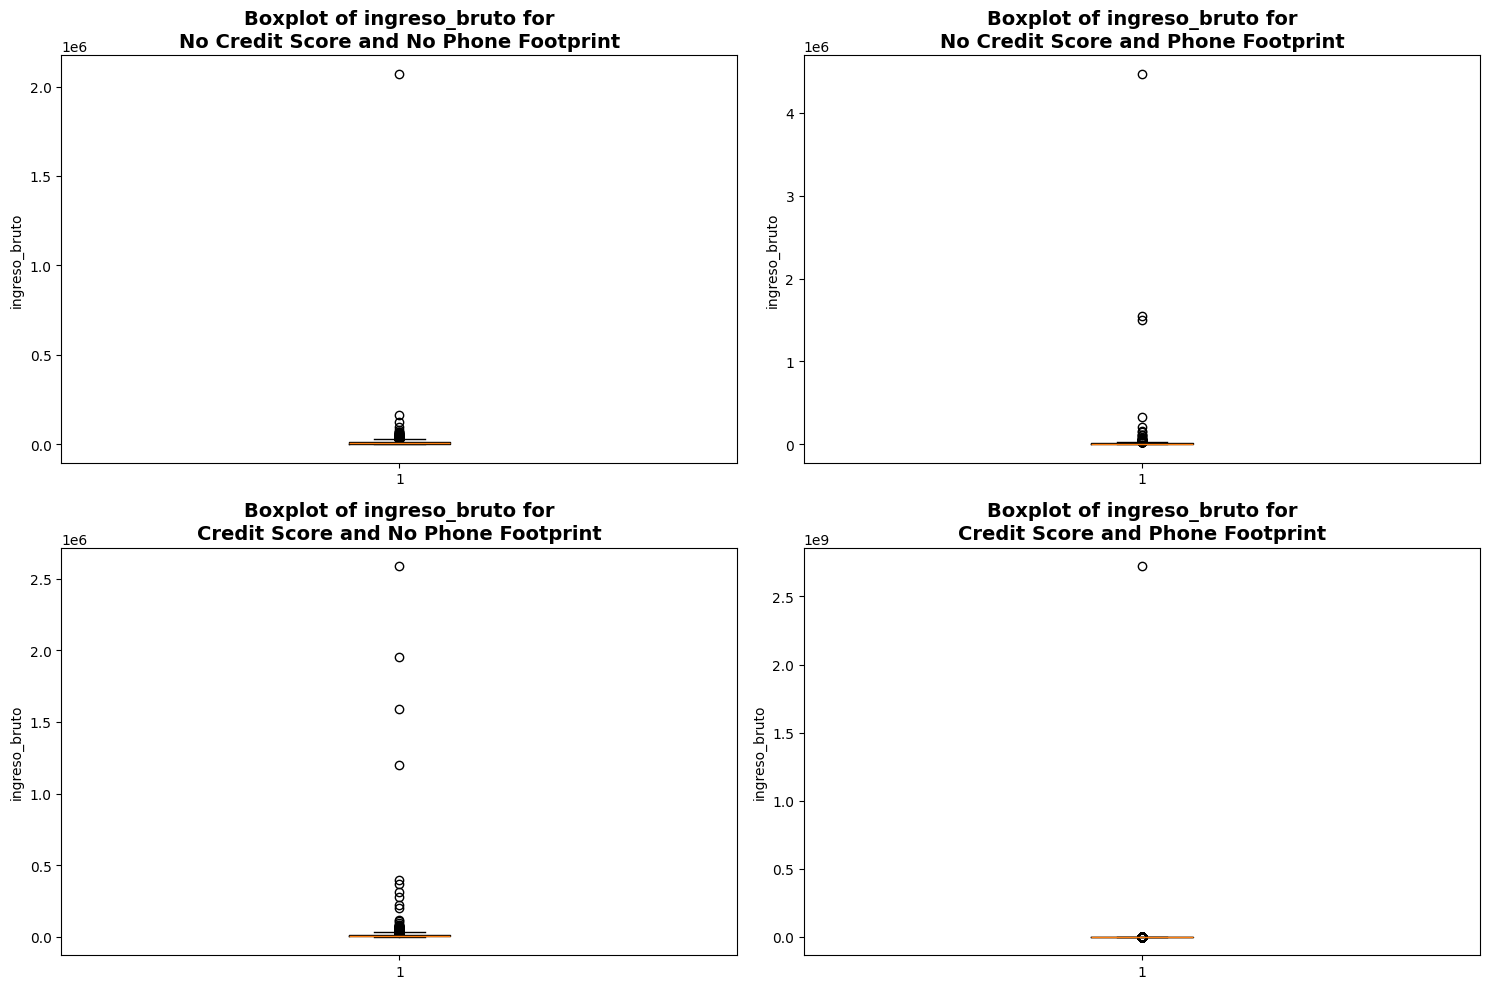

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(1, 5):
  df = globals()[f'df_score_{i}']
  axes[i-1].boxplot(df['ingreso_bruto'])
  axes[i-1].set_title(f'Boxplot of ingreso_bruto for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
  axes[i-1].set_ylabel('ingreso_bruto')

plt.tight_layout()
plt.show()

Before outliers correction in ingreso_bruto

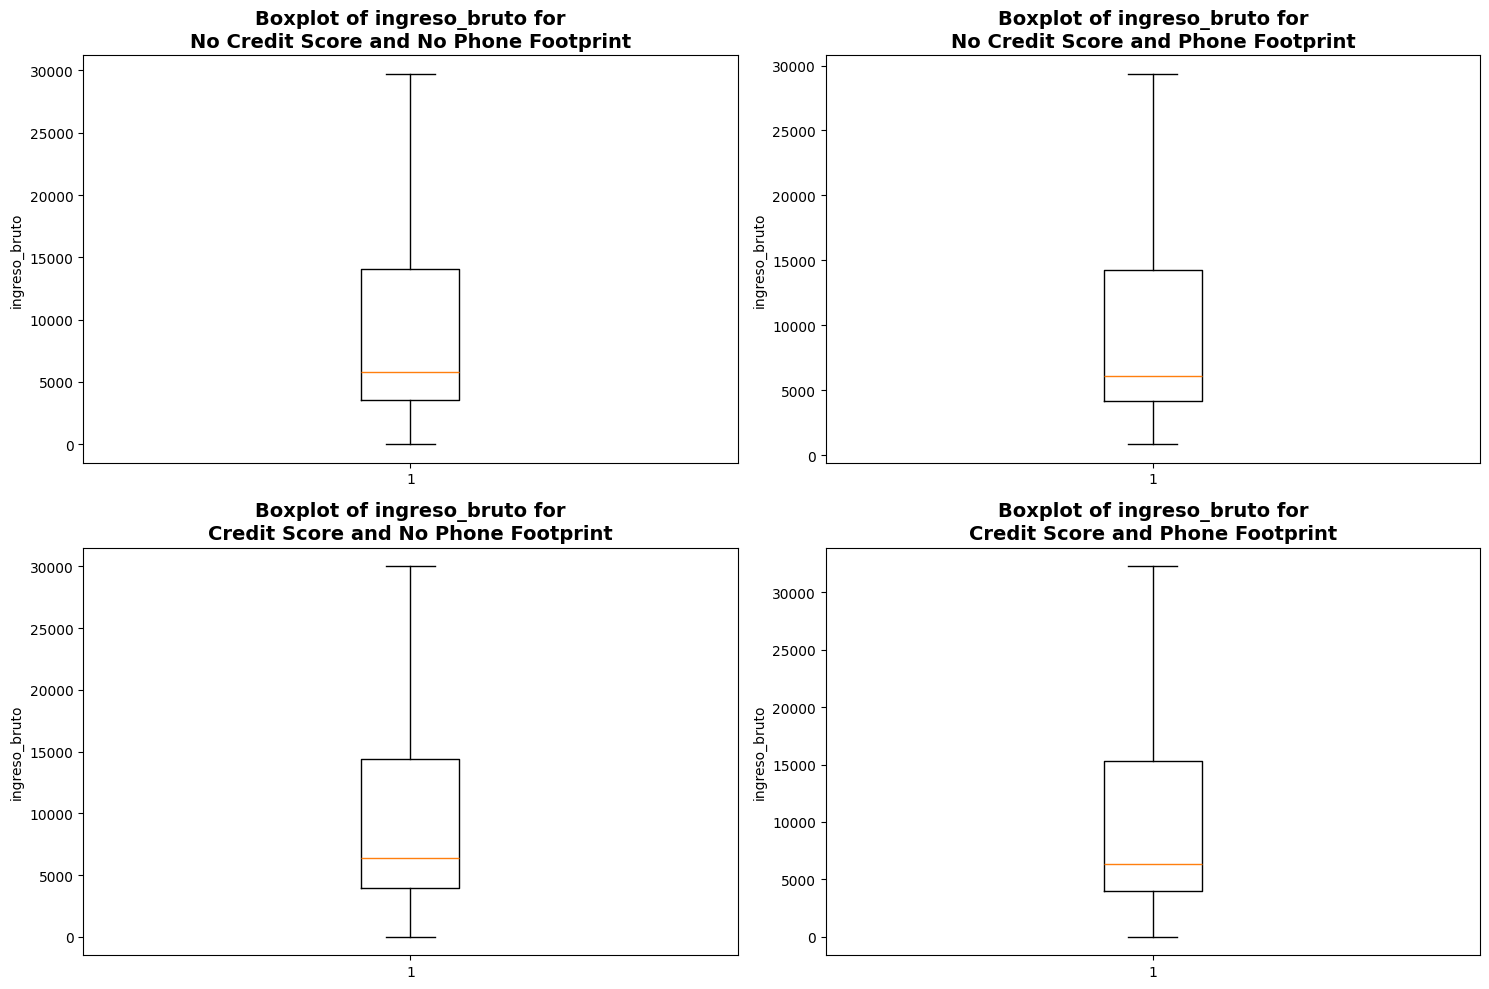

In [13]:
# Regenerate the boxplots to see the changes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(1, 5):
  # Use temporary DataFrame to avoid modifying the original one
  df = globals()[f'df_score_{i}']
  df = df.copy(deep=True)

  # Calculate the IQR and whiskers
  Q1 = df['ingreso_bruto'].quantile(0.25)
  Q3 = df['ingreso_bruto'].quantile(0.75)
  IQR = Q3 - Q1
  upper_whisker = Q3 + 1.5 * IQR
  lower_whisker = Q1 - 1.5 * IQR

  # Replace outliers with the whiskers
  df['ingreso_bruto'] = np.where(df['ingreso_bruto'] > upper_whisker, upper_whisker, df['ingreso_bruto'])
  df['ingreso_bruto'] = np.where(df['ingreso_bruto'] < lower_whisker, lower_whisker, df['ingreso_bruto'])

  # Plot the boxplot
  axes[i-1].boxplot(df['ingreso_bruto'])
  axes[i-1].set_title(f'Boxplot of ingreso_bruto for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
  axes[i-1].set_ylabel('ingreso_bruto')
  # Save new DataFrame back to the global environment
  globals()[f'df_score_{i}_clean_ib'] = df

plt.tight_layout()
plt.show()

Plotting of histogram and scatter

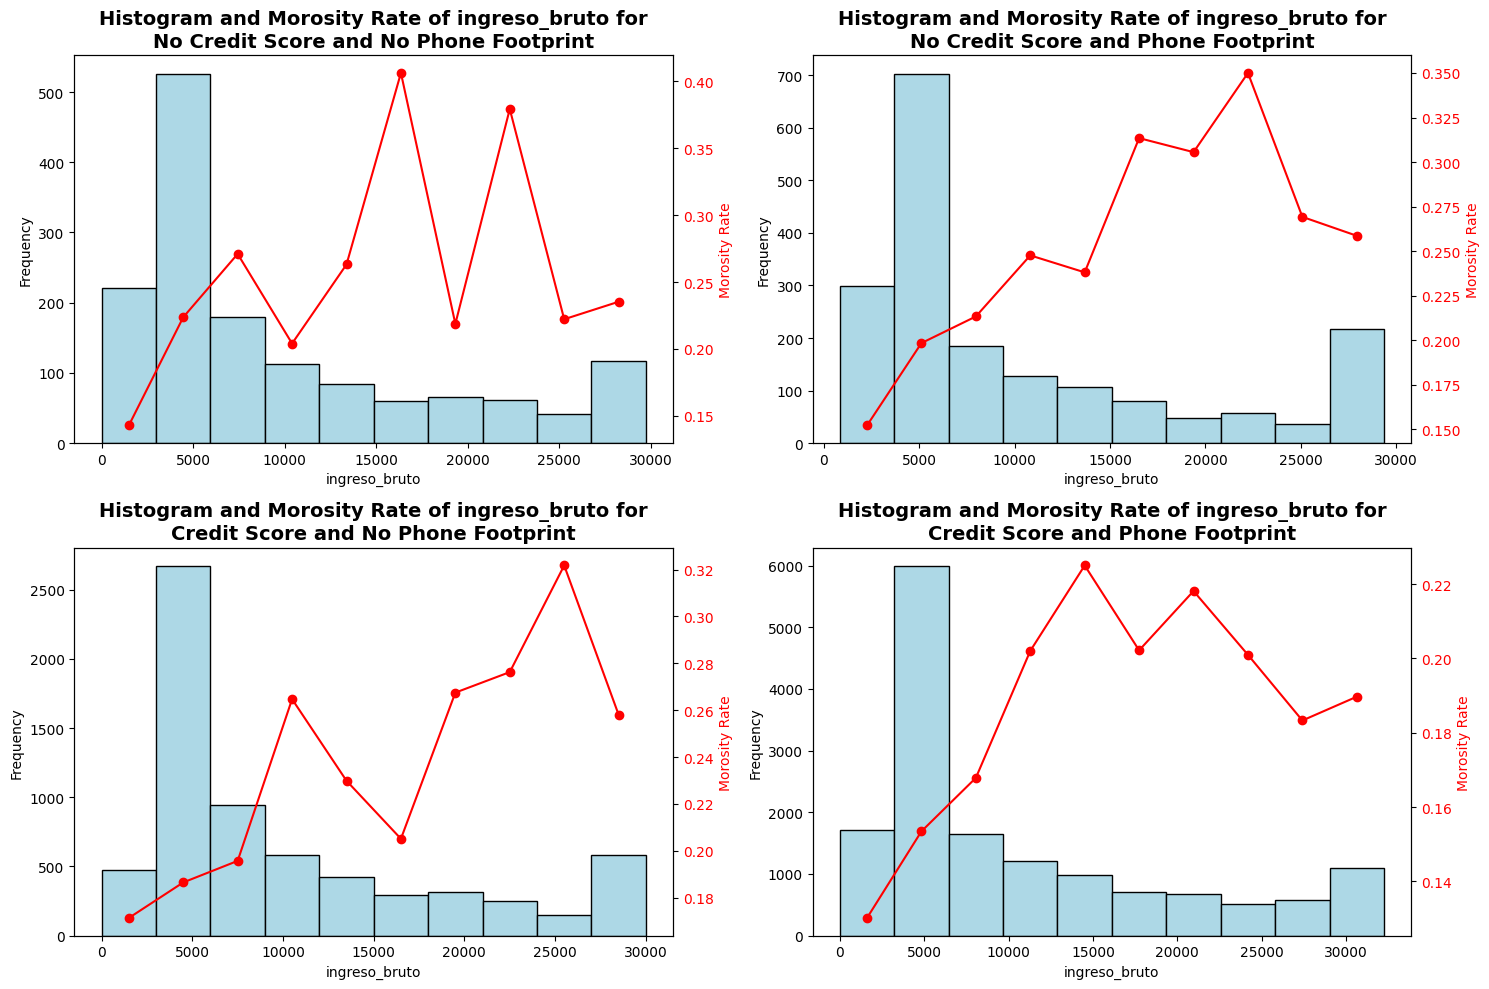

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(1, 5):
    df = globals()[f'df_score_{i}_clean_ib']

    # Calculate histogram data
    hist, bins = np.histogram(df['ingreso_bruto'], bins=10)

    # Calculate morosity rate for each bin
    morosity_rate = []
    for j in range(len(bins) - 1):
        df
        bin_df = df[(df['ingreso_bruto'] >= bins[j]) & (df['ingreso_bruto'] < bins[j + 1])]
        morosity_rate.append(bin_df[(bin_df['aprobado'] == 1) & (bin_df['malo'] >= 0)]['malo'].mean())

    # Create histogram plot
    axes[i-1].hist(df['ingreso_bruto'], bins=10, color='lightblue', edgecolor='black')
    axes[i-1].set_title(f'Histogram and Morosity Rate of ingreso_bruto for\n{groups_name[f"df_score_{i}"]}', fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel('ingreso_bruto')
    axes[i-1].set_ylabel('Frequency')

    # Create line plot for morosity rate
    ax2 = axes[i-1].twinx()
    bins_x = (bins[:-1] + bins[1:]) / 2
    ax2.plot(bins_x, morosity_rate, color='red', marker='o')
    ax2.set_ylabel('Morosity Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

#### IV and KS Indicators

##### IV

Tenemos que obtener las variables candidatas para incluir en cada modelo (un modelo por scorecard). Cada variable va a ser candidata si tiene un valor de IV Moderado o Fuerte (IV <= 0.02 No predictivo | 0.02 < IV <= 0.1 Bajo Predictivo | 0.1 < IV <= 0.3 Moderada | IV > 0.3 Fuerte)

In [37]:
def create_bins(df):
    df = df.copy(deep=True)
    df['ingreso_bruto_bin'] = pd.qcut(df['ingreso_bruto'], q=5, labels=False)
    return df

def create_scorecard_dataframe(df):
    result = df.groupby('ingreso_bruto_bin').agg({
        'malo': ['sum', 'count']
    })
    
    result.columns = ['malos', 'total']
    result['buenos'] = result['total'] - result['malos']
    result['buenos_pct'] = (result['total'] - result['malos']) / result['total']
    result['malos_pct'] = result['malos'] / result['total']
    result['pre_icv'] = (result['buenos_pct'] - result['malos_pct']) * np.log(result['buenos_pct'] / result['malos_pct'])
    result = result.reset_index()
    result['ingreso_bruto_bin'] = result['ingreso_bruto_bin'] + 1  # Add 1 to make bins 1-indexed
    return result[['ingreso_bruto_bin', 'malos', 'buenos', 'malos_pct', 'buenos_pct', 'pre_icv']]

# Create 4 DataFrames, one per ScoreCard with 5 bins each
scorecard_dataframes = {}
for i in range(1, 5):
    df_name = f'df_score_{i}_clean_ib'
    df = globals()[df_name]
    df = df[df['aprobado'] == 1]
    df = create_bins(df)
    scorecard_dataframes[f'scorecard_{i}'] = create_scorecard_dataframe(df)

# Print the resulting dataframes
for scorecard, df_temp in scorecard_dataframes.items():
    print(f"\nDataframe for {scorecard}:")
    print(df_temp)

# Compute the IV for each ScoreCard
def classify_iv(iv):
    if iv < 0.02:
        return 'No predictive'
    elif iv <= 0.1:
        return 'Low predictive'
    elif iv <= 0.3:
        return 'Moderate'
    elif iv > 0.3:
        return 'Strong'

scorecard_iv_dict = {}
for scorecard, df in scorecard_dataframes.items():
    total_iv = df['pre_icv'].sum()
    scorecard_iv_dict[scorecard] = [total_iv, classify_iv(total_iv)]

# Print the IV results
for scorecard, (iv, classification) in scorecard_iv_dict.items():
    print(f"{scorecard}: Total IV = {iv:.4f}, Classification: {classification}")


Dataframe for scorecard_1:
   ingreso_bruto_bin  malos  buenos  malos_pct  buenos_pct   pre_icv
0                  1     25     133   0.158228    0.841772  1.142526
1                  2     33     125   0.208861    0.791139  0.775482
2                  3     38     120   0.240506    0.759494  0.596786
3                  4     42     116   0.265823    0.734177  0.475811
4                  5     46     112   0.291139    0.708861  0.371713

Dataframe for scorecard_2:
   ingreso_bruto_bin  malos  buenos  malos_pct  buenos_pct   pre_icv
0                  1     52     253   0.170492    0.829508  1.042660
1                  2     46     260   0.150327    0.849673  1.211296
2                  3     71     228   0.237458    0.762542  0.612597
3                  4     69     234   0.227723    0.772277  0.665018
4                  5     78     225   0.257426    0.742574  0.513962

Dataframe for scorecard_3:
   ingreso_bruto_bin  malos  buenos  malos_pct  buenos_pct   pre_icv
0                  

##### KS

### Load

## Training Models